In [26]:
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from math import pi
from matplotlib import gridspec
import itertools
import time
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import orbithunter as orb
import pandas as pd

# Hunting for Orbits 

Each spatiotemporal solution  to the KSE is a scalar spatiotemporal velocity field $u(t,x)$ which satisfies the equation
\begin{equation}
F(u) = u_t + u_{xx}+ u_{xxxx} + \frac{1}{2}\partial_x u^2 = 0
\end{equation}

In order to find these solutions, we need initial guesses. These guess orbits can be produced in unsupervised and
supervised manners. The unsupervised method is to initialize a random spectrum of Fourier coefficients, and then modulate it
to represent the typical physical scales of the problem. When there are no obvious physical scales, this can be a dark art.
However, we are benefited by the variational formulation. Namely, we can exploit this by actually making *worse* initial conditions. By doing so, we are raising the cost. To demonstrate why this can be beneficial it is important to remember
how we are finding the solutions; namely, we are using descent/inexact Newton/quasi-Newton methods, typically with simple backtracking. Hunting can fail under a number of circumstances: the number of iterations exceeds the maximum allowed (varies
highly between methods), the step size becomes too small, or the residual is not decreasing enough (vanishing gradient). 

The analogy I like to use is thus: if you are trying to descend a mountain under the constraint that you can only ever move downwards, then it can be better to start higher up the mountain lest you get stuck at a cliff face. "higher" up the mountain is analogous to higher cost. The issue with starting higher up the mountain, is that certain components of the gradient can be incredibly large; especially the gradients of the dimensions of the configuration spoace.
Therefore I highly recommend including a rescaling operation (preconditioning when talking about solving linear systems)
that rescales these components. 

The "good" methods are highly dependent on problem; with square systems I would recommend solving the system directly when small enough, and with the sparse linear algebra methods when not. For the underdetermined systems I have found preconditioned "adjoint descent" which in the discrete case is just gradient descent.

## Spectral modulation methods for the Kuramoto-Sivashinsky equation.

The listed pairs are the possible modulation strategies included in orbithunter for the KSE. What is not listed are
the hyperparameters, namely the "mean" and "variance" of the mollifiers. I use these terms because I feel like they are the
most understandable to a wider audience even though there is no statistics nor probability distributions to speak of. They
are elementwise filters 

In [27]:
space_tactics = ["gaussian", "laplace", "laplace_sqrt", "plateau_lienar", "exponential_linear", "flat_top", "random"]
time_tactics = ["gaussian", "laplace", "truncate", "flat_top", "laplace_plateau","random"]
print(f"There are {len(list(itertools.product(space_tactics, time_tactics)))} built in modulation combinations"
      f" for the KSE; this does not take hyperparameters into account.")
list(itertools.product(space_tactics, time_tactics))

There are 42 built in modulation combinations for the KSE; this does not take hyperparameters into account.


[('gaussian', 'gaussian'),
 ('gaussian', 'laplace'),
 ('gaussian', 'truncate'),
 ('gaussian', 'flat_top'),
 ('gaussian', 'laplace_plateau'),
 ('gaussian', 'random'),
 ('laplace', 'gaussian'),
 ('laplace', 'laplace'),
 ('laplace', 'truncate'),
 ('laplace', 'flat_top'),
 ('laplace', 'laplace_plateau'),
 ('laplace', 'random'),
 ('laplace_sqrt', 'gaussian'),
 ('laplace_sqrt', 'laplace'),
 ('laplace_sqrt', 'truncate'),
 ('laplace_sqrt', 'flat_top'),
 ('laplace_sqrt', 'laplace_plateau'),
 ('laplace_sqrt', 'random'),
 ('plateau_lienar', 'gaussian'),
 ('plateau_lienar', 'laplace'),
 ('plateau_lienar', 'truncate'),
 ('plateau_lienar', 'flat_top'),
 ('plateau_lienar', 'laplace_plateau'),
 ('plateau_lienar', 'random'),
 ('exponential_linear', 'gaussian'),
 ('exponential_linear', 'laplace'),
 ('exponential_linear', 'truncate'),
 ('exponential_linear', 'flat_top'),
 ('exponential_linear', 'laplace_plateau'),
 ('exponential_linear', 'random'),
 ('flat_top', 'gaussian'),
 ('flat_top', 'laplace'),
 ('

Just to get an idea into the "look" of each modulation and the subsequent (crude) optimization result

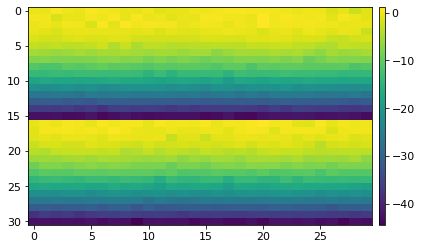

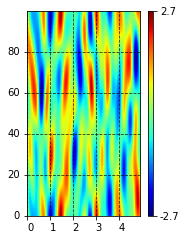

In [28]:
st, tt = list(itertools.product(space_tactics, time_tactics))[0]
orbit = orb.OrbitKS(parameters=(100, 44, 0.)).populate(attr='state', seed=5, spatial_modulation='laplace_sqrt',
                                                   xscale=44/(2*pi*np.sqrt(2)), xvar=2, 
                                                   tvar=1, tscale=1, temporal_modulation='gaussian')
orbit.mode_plot()
orbit.plot(padding=True)

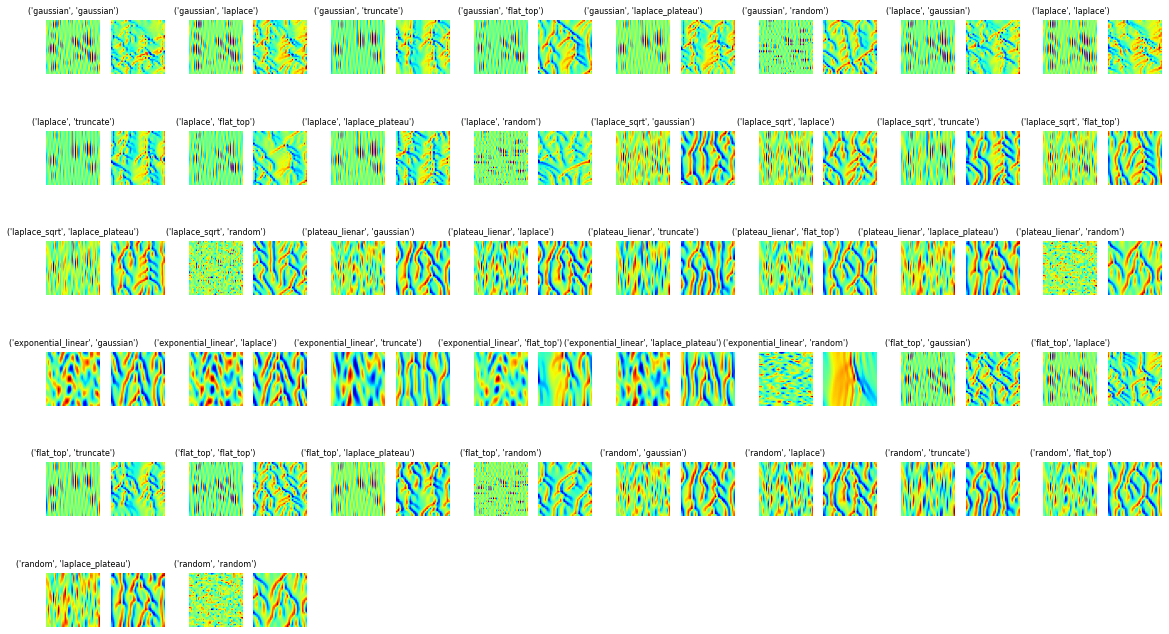

In [4]:
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(84//8, 8)
for i, (st, tt) in enumerate(itertools.product(space_tactics, time_tactics)):
    example_orbit = orb.OrbitKS(parameters=(44, 44, 0.)).populate(attr='state', seed=5, spatial_modulation=st, xscale=44/pi,
                                                                   temporal_modulation=tt, xshift='sqrt').rescale(5)
    
    result = orb.hunt(example_orbit, preconditioning=[True, False], methods=('adj', 'lsmr'),
                      maxiter=[10000, 10], scipy_kwargs={"atol":1e-4,"btol":1e-4})
    gsi = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[i])
    ax = plt.subplot(gsi[0])
    ax2 = plt.subplot(gsi[1])
    ax.imshow(example_orbit.transform(to='field').state, cmap='jet')
    ax2.imshow(result.orbit.transform(to='field').state, cmap='jet')
    ax.axis('off')
    ax.set_title((st, tt), fontsize=8)
    ax2.axis('off')

plt.show()

Compare these results with a random solution to see which ones produced good results (note that the actual number of iterations is far fewer than I would recommend using)

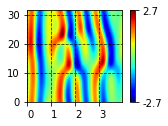

In [6]:
np.random.seed(22)
np.random.choice(orb.read_h5('./data/OrbitKS.h5')).plot(padding=True)

      
# How flexible and how much control does orbithunter give me?

Why should you use orbithunter instead of just using SciPy or NumPy or ... directly? One of the main design goal was flexibility and usability. How do you solve $F(x)=0$ and $0.5*|F(x)|^2 = 0$? The root solving problem can be solved by solving
the linear Newton system $\nabla F \delta x = - F$ iteratively, that is, $x_{n} = x_{n-1} - (\nabla F)^{-1} F$ iteratively (with backtracking a step size $\tau$ is also included on the second term. Alternatively, we can find minimizers of $1/2 |F|^2$ by finding directions of descent; those which decrease its value. Ok, well how do we do all of that? We can either write a custom algorithm or leverage smart people's results and use, for example, SciPy. 

Ok well then this begs the question: what do we need to use SciPy's algorithms? Well it depends. A lot. Sometimes you have to construct a matrix. Sometimes you need to provide a callable function. Sometimes you need to provide a callable function, its jacobian, and Hessian. Sometimes these methods return a `vector`, sometimes they return a `tuple` of runtime information, sometime they return an `OptimizeResult`. What if your cost function has extra arguments which depend on the current state but is too hard to update within the SciPy routines? What if you would want to exit and re-enter these algorithms? Modify the default arguments? 

The point I am trying to make is that I have tried to do the hard work for you by wrapping all of these routines with the orbithunter api. Now, all you need to do is pass `Orbit` (or subclass) instances, the methods you want to use, and the extra keyword arguments therein. 

In [ ]:
# Apply the hybrid method that was used as the primary method, historically. 
t0 = time.time_ns()/10**9
example_orbit = orb.OrbitKS(parameters=(44, 44, 0.)).populate(attr='state', seed=5,
                                                              spatial_modulation='plateau_linear',
                                                              xscale=44/pi,
                                                               temporal_modulation='laplace_plateau',
                                                              xshift='sqrt').rescale(5)
result = orb.hunt(example_orbit, preconditioning=[True, False, False],
                  methods=('adj', 'lsmr', 'lsqr'), verbose=True,
                  maxiter=[10000, 500, 100],
                  scipy_kwargs=[{}, {"atol":1e-4,"btol":1e-4}, {"atol":1e-6,"btol":1e-6}])
t1 = time.time_ns()/10**9
print(f"The numerical optimization took {t1-t0} seconds to complete {result.maxiter} iterations for each method")

In [30]:
# Apply the hybrid method that was used as the primary method, historically. 
t0 = time.time_ns()/10**9
example_orbit = orb.OrbitKS(parameters=(44, 44, 0.)).populate(attr='state', seed=5,
                                                              spatial_modulation='plateau_linear',
                                                              xscale=44/pi,
                                                               temporal_modulation='laplace_plateau',
                                                              xshift='sqrt').rescale(5)
result = orb.hunt(example_orbit, preconditioning=[True, False], methods=('adj', 'lsmr'), verbose=True,
                  maxiter=[100000, 1000], scipy_kwargs=[{}, {"atol":1e-4,"btol":1e-4}])
t1 = time.time_ns()/10**9
print(f"The numerical optimization took {t1-t0} seconds to complete {result.maxiter} iterations for each method")


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [44, 44, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 42694.2804066195
Target cost tolerance : 1e-06
Maximum iteration number : 10000
Preconditioning : True
-------------------------------------------------------------------------------------------------
#################################################
 Residual=4.1935159 after 5000 adjoint descent steps. Parameters=(44.49044155538786, 44.000294531039714, 0.0)
#################################################
------------------------------------------------------------------------------------------------
Starting lsmr optimization
Initial guess : OrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [44.637, 44.0, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 2.0398317673724495
Ta

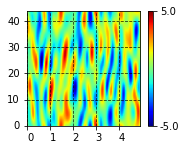

0.0004617958973487257


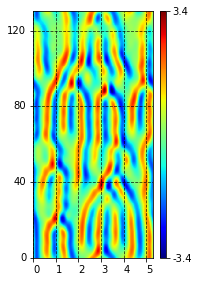

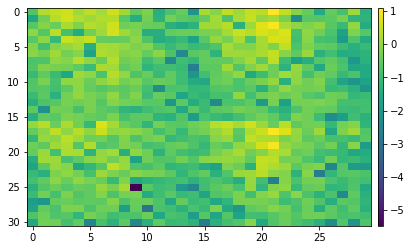

In [33]:
example_orbit.plot(padding=True)
print(result.orbit.cost())
result.orbit.plot(padding=True)
result.orbit.mode_plot()

In [6]:
# Apply the hybrid method that was used as the primary method, historically. 
t0 = time.time_ns()/10**9
example_orbit = orb.OrbitKS(parameters=(44, 44, 0.)).populate(attr='state', seed=5, spatial_modulation='plateau_linear', xscale=44/pi,
                                                               temporal_modulation='laplace_plateau', xshift='sqrt').rescale(5)
result = orb.hunt(example_orbit, preconditioning=[False, False], methods=('adj', 'lsmr'), verbose=True,
                  maxiter=[10000, 1000], scipy_kwargs={"atol":1e-4,"btol":1e-4})
t1 = time.time_ns()/10**9

print(f"dimensions {result.orbit.dimensions()}")
print(f"The numerical optimization took {t1-t0} seconds to complete {result.maxiter} iterations for each method")
print(f"The residual of the optimization result is {result.orbit.cost()}")
result.orbit.plot(padding=True)
result.orbit.mode_plot()


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [44, 44, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 42694.2804066195
Target cost tolerance : 1e-06
Maximum iteration number : 10000
Preconditioning : False
-------------------------------------------------------------------------------------------------
#################################################
 Residual=5.4385971 after 5000 adjoint descent steps. Parameters=(250.25941780020912, 1163.3805352600807, 0.0)
#################################################
------------------------------------------------------------------------------------------------
Starting lsmr optimization
Initial guess : OrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [271.534, 1162.642, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 2.688544046148

In [32]:
print(f"The numerical optimization took {t1-t0} seconds to complete {result.maxiter} iterations for each method")

The numerical optimization took 420.5162842273712 seconds to complete [10000, 500, 100] iterations for each method


# Why is this useful?

For those unfamiliar with the field of nonlinear dynamics and chaos, all we have shown so far is randomly initialized numbers
and the results of some crude optimization. 

The point is that most studies of the KSE have been on relatively small computational domains (L=22 and L=38.5 in the antisymmetric subspace for two examples). Additionally, exponential instability in the dynamical systems formulation means that
***no one*** (to my knowledge) has been able to find unstable periodic orbits from random noise. Additionally ***no one*** has even considered allowing the spatial domain size to vary. 

Orbithunter does all three of these by default, as I will show in the next example. First, construct an initial guess on a
very large spatiotemporal domain: $(T,L)=(300,\;33(2\pi\sqrt{2})$; remember, $L=22$ is a common size. 

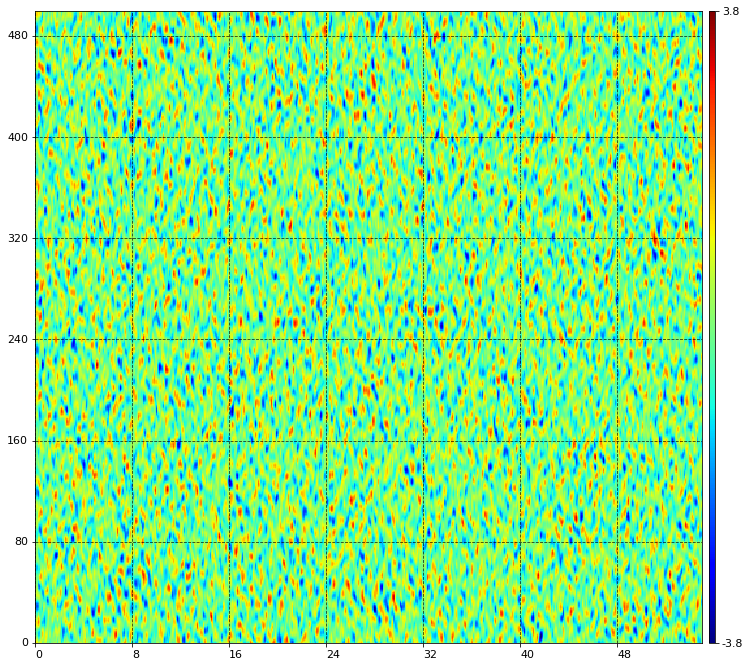

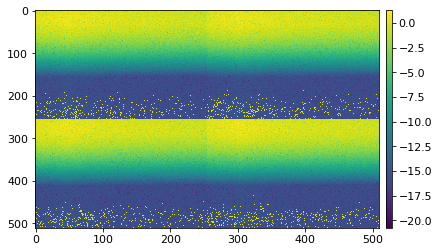

In [36]:
T, L = 500,  55*2*pi*np.sqrt(2)
largeorbkwargs = {"seed":49, "temporal_modulation":'gaussian', "spatial_modulation":'laplace_sqrt',
                  "tvar":256, "tscale":20, "xscale":45, "xvar":32, "xshift":"log", "discretization":(1024, 1024)}
params =(T, L, 0.)
large_orb = orb.RelativeOrbitKS(parameters=params).populate(**largeorbkwargs)
large_orb = large_orb.rescale(4.).transform(to='field').resize(512, 512)
large_orb.plot()
large_orb.mode_plot()

By manipulating the Fourier coefficients, we have produced an initial condition which is attempting to emulate
the shape of the solutions of the KSE. Next, run it through some optimization algorithms to see how close we can get to a solution.

In [37]:
if not os.path.isfile("./data/large_hunting_example.h5"):
    # set the number of cores for FFT computations to 4; this may need to be removed for unapplicable systems.
    large_orb.workers = 4
    t0 = time.time_ns()/10**9
    large_orb_result = orb.hunt(large_orb.transform(to='modes'),
                                verbose=True,
                                methods='adj',
                                maxiter=100000,
#                                 pexp=(2, 2),
#                                 preconditioning=True
                               )
    t1 = time.time_ns()/10**9
(t1-t0)


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [511, 510], "basis": "modes", "parameters": [500, 488.717, 0]})
Constraints : {'t': False, 'x': False, 's': False}
Initial cost : 10491115.120791662
Target cost tolerance : 1e-06
Maximum iteration number : 100000
Preconditioning : False
-------------------------------------------------------------------------------------------------
#################################################
 Residual=6643.6256431 after 5000 adjoint descent steps. Parameters=(1389.0060344096069, 4205.2562580545455, 13.142215395125188)
#################################################
 Residual=3085.7113513 after 10000 adjoint descent steps. Parameters=(1541.183867363905, 4247.987252019713, 13.691635475517206)
#################################################
 Residual=1935.0710866 after 15000 adjoint descent steps. Parameters=(1633.4486161309055, 42

10211.01436161995

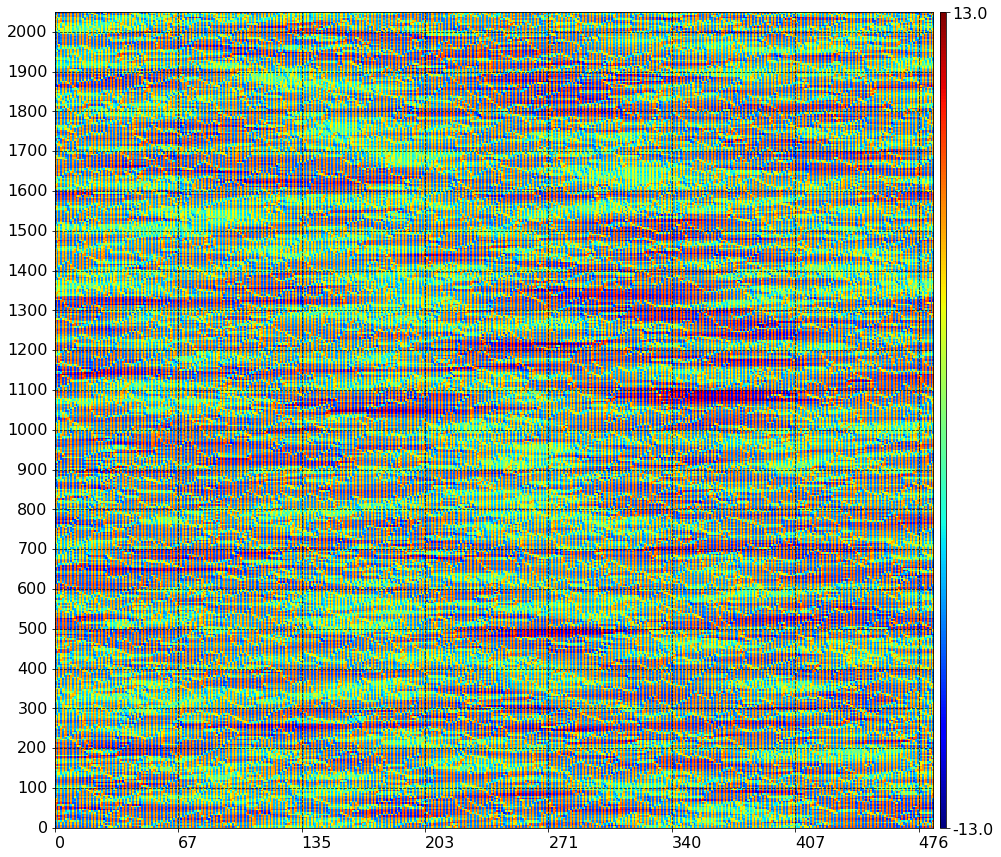

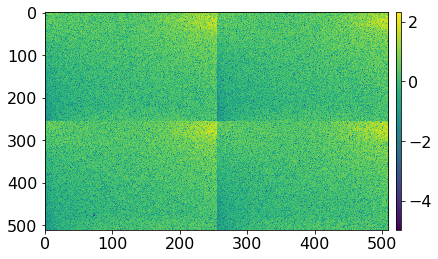

214.5618843288961

In [38]:
large_orb_result.orbit.plot()
large_orb_result.orbit.mode_plot()
large_orb_result.orbit.cost()
# large_orb_result.orbit.to_h5('large_adjoint.h5')

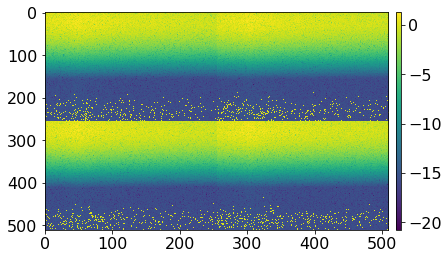

In [39]:
large_orb.mode_plot()

In [ ]:
if not os.path.isfile("./data/large_hunting_example.h5"):
    # set the number of cores for FFT computations to 4; this may need to be removed for unapplicable systems.
    large_orb.workers = 4
    t0 = time.time_ns()/10**9
    large_orb_result = orb.hunt(large_orb,
                                verbose=True,
                                methods='minres',
                                maxiter=100000,
                               )
    t1 = time.time_ns()/10**9
(t1-t0)

In [ ]:
large_orb_result.orbit.plot()
large_orb_result.orbit.cost()
large_orb_result.orbit.to_h5('large_final.h5')

Now, just for fun, I let the following run with the knowledge that it was going to take a very long time; let's see how close
I can get to a periodic orbit at this size. Depending on the tolerance this could be the largest periodic orbit ever found.
It has 250k computational degrees of freedom, all of which are highly coupled in a nonlinear manner. 

# How do I choose a numerical method?

In the world of data scientists, "there is no free lunch" is a common idiom. Which methods work best for a problem is
highly dependent on the problem; the only general recommendations are:

    1. Never use a method which constructs matrices on large problems, you'll run out of memory.
    2. Do NOT use the following for the KSE: diagbroyden, cobyla, slsqp, nelder-mead, powell, excitingmixing, linearmixing,
       broyden1, broyden2, anderson, df-sane. They either perform incredibly poorly or take an incredible amount of time.
    3. For "bad" initial conditions: use preconditioning. especially on the derivatives w.r.t. dimensional parameters.
       Preconditioning is not built in; it is on you. I highly recommend including a flag for preconditioning in your
       `rmatvec` method, as then it can be enabled for adjoint descent / gradient descent / other methods. 

It is hard to quantify the performances of each method; the most important consideration to keep in mind is how they scale with memory. This is compounded with the fact that SciPy's default arguments 

In [197]:
import pandas as pd

The original orbit


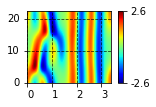

The original orbit plus some noise


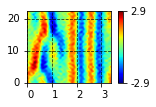

In [232]:
np.random.seed(0)
initial = orb.read_h5('./data/OrbitKS.h5')[77].resize(40, 40).transform(to='field')
print("The original orbit")
initial.plot(padding=True)
initial += 0.2 * np.random.randn(*initial.shape)
initial.transform(to='modes', inplace=True)
print("The original orbit plus some noise")
initial.plot(padding=True)

In [27]:
df = pd.read_csv('./data/numerical_time_trials.csv', index_col=0)
df.columns = ['time', 't', 'x']+df.columns.tolist()[3:]
df.columns = [col.strip() for col in df.columns]
df.loc[:,'t'] = df.loc[:,'t'].apply(lambda x : x.split('(')[1]).values
df.loc[:,'x'] = df.loc[:,'x'].apply(lambda x : x.split(')')[0]).values

In [29]:
# Note that TNC has the largest reduction per seconds, but the dimensions were too distorted. 
df.sort_values(by='cost reduction per second', ascending=False)

,time,t,x,cost,cost reduction,cost reduction per second,cost reduction per step
tnc,0.085000,121.65704150779563,119.51034613583289,20.942732,2186.805171,25727.108113,218.680517
cgs,0.176998,78.76628710258889,37.3958438329021,1.165143,2206.582760,12466.700380,220.658276
l-bfgs-b,0.248128,78.765359037152,37.378810149721396,28.279417,2179.468486,8783.631224,217.946849
cg_min,0.288577,78.7664244609136,37.38077398906541,0.850202,2206.897701,7647.521856,220.689770
cg,0.315285,78.76740525702598,37.34744948474136,0.377361,2207.370542,7001.186548,220.737054
minres,0.333291,78.76732122182642,37.345884341910384,0.384872,2207.363031,6622.938613,220.736303
trust-ncg,0.546312,78.77058584397481,37.26260211091978,0.048077,2207.699826,4041.094619,220.769983
trust-krylov,0.559934,78.77058584397481,37.26260211091978,0.048077,2207.699826,3942.784823,220.769983
qmr,0.588853,78.76732122182642,37.34588434191038,0.384872,2207.363031,3748.583035,220.736303
bicg,0.603259,78.76740525702598,37.34744948474136,0.377361,2207.370542,3659.078389,220.737054


# Happy hunting!